In [3]:
import csv
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

import numpy as np
import geopandas as gpd
import pandas as pd
from fiona.crs import from_epsg
import pysal as ps

import shapely

#from sklearn import naive_bayes
#from sklearn import svm
#from sklearn.model_selection import train_test_split
#from sklearn import cluster

import ast
from cStringIO import StringIO
import requests
import os
import json
import urllib
import urllib2

from time import sleep
from IPython.display import clear_output

In [4]:
subStations = gpd.GeoDataFrame.from_file('Subway Stations.geojson')

subStations.crs = from_epsg(4326)

In [5]:
print (len(subStations))
print (len(subStations)*2.3)/60
sleep(2.3)

473
18.1316666667


In [6]:

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [7]:
def getXY(pt):
    return pt.x, pt.y

In [8]:
subStations['polygon'] = 0

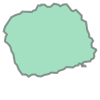

In [9]:
walkingdistance='15'
url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+str(getXY(subStations.geometry.iloc[0])[1])+',"lon":'+str(getXY(subStations.geometry.iloc[0])[0])+'}],"costing":"pedestrian","contours":[{"time":' + walkingdistance + ',"color":"ff0000"}]}&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))
response = urllib2.urlopen(url)
data = response.read().decode('utf-8')
dataDict = json.loads(data)
subStations.loc[0,'polygon'] = Polygon(dataDict['features'][0]['geometry']['coordinates'])
sleep(2.3) ### avoid being blocked by the MapzenAPI services
Polygon(dataDict['features'][0]['geometry']['coordinates'])

In [10]:
i=0
for station in subStations.geometry[1:]:
    i+=1
    clear_output()
    print float(i)/float(len(subStations))
    url='http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+str(getXY(station)[1])+',"lon":'+str(getXY(station)[0])+'}],"costing":"pedestrian","contours":[{"time":' + walkingdistance + ',"color":"ff0000"}]}&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))
    response = urllib2.urlopen(url)
    data = response.read().decode('utf-8')
    dataDict = json.loads(data)
    subStations.loc[i,'polygon'] = Polygon(dataDict['features'][0]['geometry']['coordinates'])
    #mainPolygon = cascaded_union([mainPolygon,secPolygon])
    sleep(2.3)

0.997885835095


In [11]:
subStations.head()

geometry           line  \
0  POINT (-73.99106999861967 40.73005400028978)  4-6-6 Express   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   
3  POINT (-73.97499915116808 40.68086213682956)          2-3-4   
4  POINT (-73.89488591154061 40.66471445143568)            3-4   

               name                                              notes  \
0          Astor Pl  4 nights, 6-all times, 6 Express-weekdays AM s...   
1          Canal St  4 nights, 6-all times, 6 Express-weekdays AM s...   
2           50th St                              1-all times, 2-nights   
3         Bergen St           4-nights, 3-all other times, 2-all times   
4  Pennsylvania Ave                        4-nights, 3-all other times   

  objectid                                url  \
0        1  http://web.mta.info/nyct/service/   
1        2  http://web.mta.info/nyct/service/   
2        3  http://web.mta.info/nyct/service/   
3        4  http://web.mta.info/nyct/service/   
4        5  http://web.mta.info/nyct/service/   

                                             polygon  
0  POLYGON ((-73.984787 40.741348, -73.98349 40.7...  
1  POLYGON ((-73.99118799999999 40.730087, -73.99...  
2  POLYGON ((-73.97782100000001 40.772755, -73.97...  
3  POLYGON ((-73.972786 40.692078, -73.9720229999...  
4  POLYGON ((-73.89574399999999 40.67585, -73.894...

In [12]:
WDsubStations= subStations.copy(deep=True)

In [13]:
WDsubStations.drop('geometry',inplace=True, axis=1)

In [14]:
WDsubStations =  gpd.GeoDataFrame(WDsubStations, crs=WDsubStations.crs, geometry=WDsubStations.polygon)
WDsubStations.drop('polygon',inplace=True, axis=1)
WDsubStations.head()
#WDsubStations = WDsubStations.rename(columns={'polygon': 'geometry'})

line              name  \
0  4-6-6 Express          Astor Pl   
1  4-6-6 Express          Canal St   
2            1-2           50th St   
3          2-3-4         Bergen St   
4            3-4  Pennsylvania Ave   

                                               notes objectid  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   
3           4-nights, 3-all other times, 2-all times        4   
4                        4-nights, 3-all other times        5   

                                 url  \
0  http://web.mta.info/nyct/service/   
1  http://web.mta.info/nyct/service/   
2  http://web.mta.info/nyct/service/   
3  http://web.mta.info/nyct/service/   
4  http://web.mta.info/nyct/service/   

                                            geometry  
0  POLYGON ((-73.984787 40.741348, -73.98349 40.7...  
1  POLYGON ((-73.99118799999999 40.730087, -73.99...  
2  POLYGON ((-73.97782100000001 40.772755, -73.97...  
3  POLYGON ((-73.972786 40.692078, -73.9720229999...  
4  POLYGON ((-73.89574399999999 40.67585, -73.894...

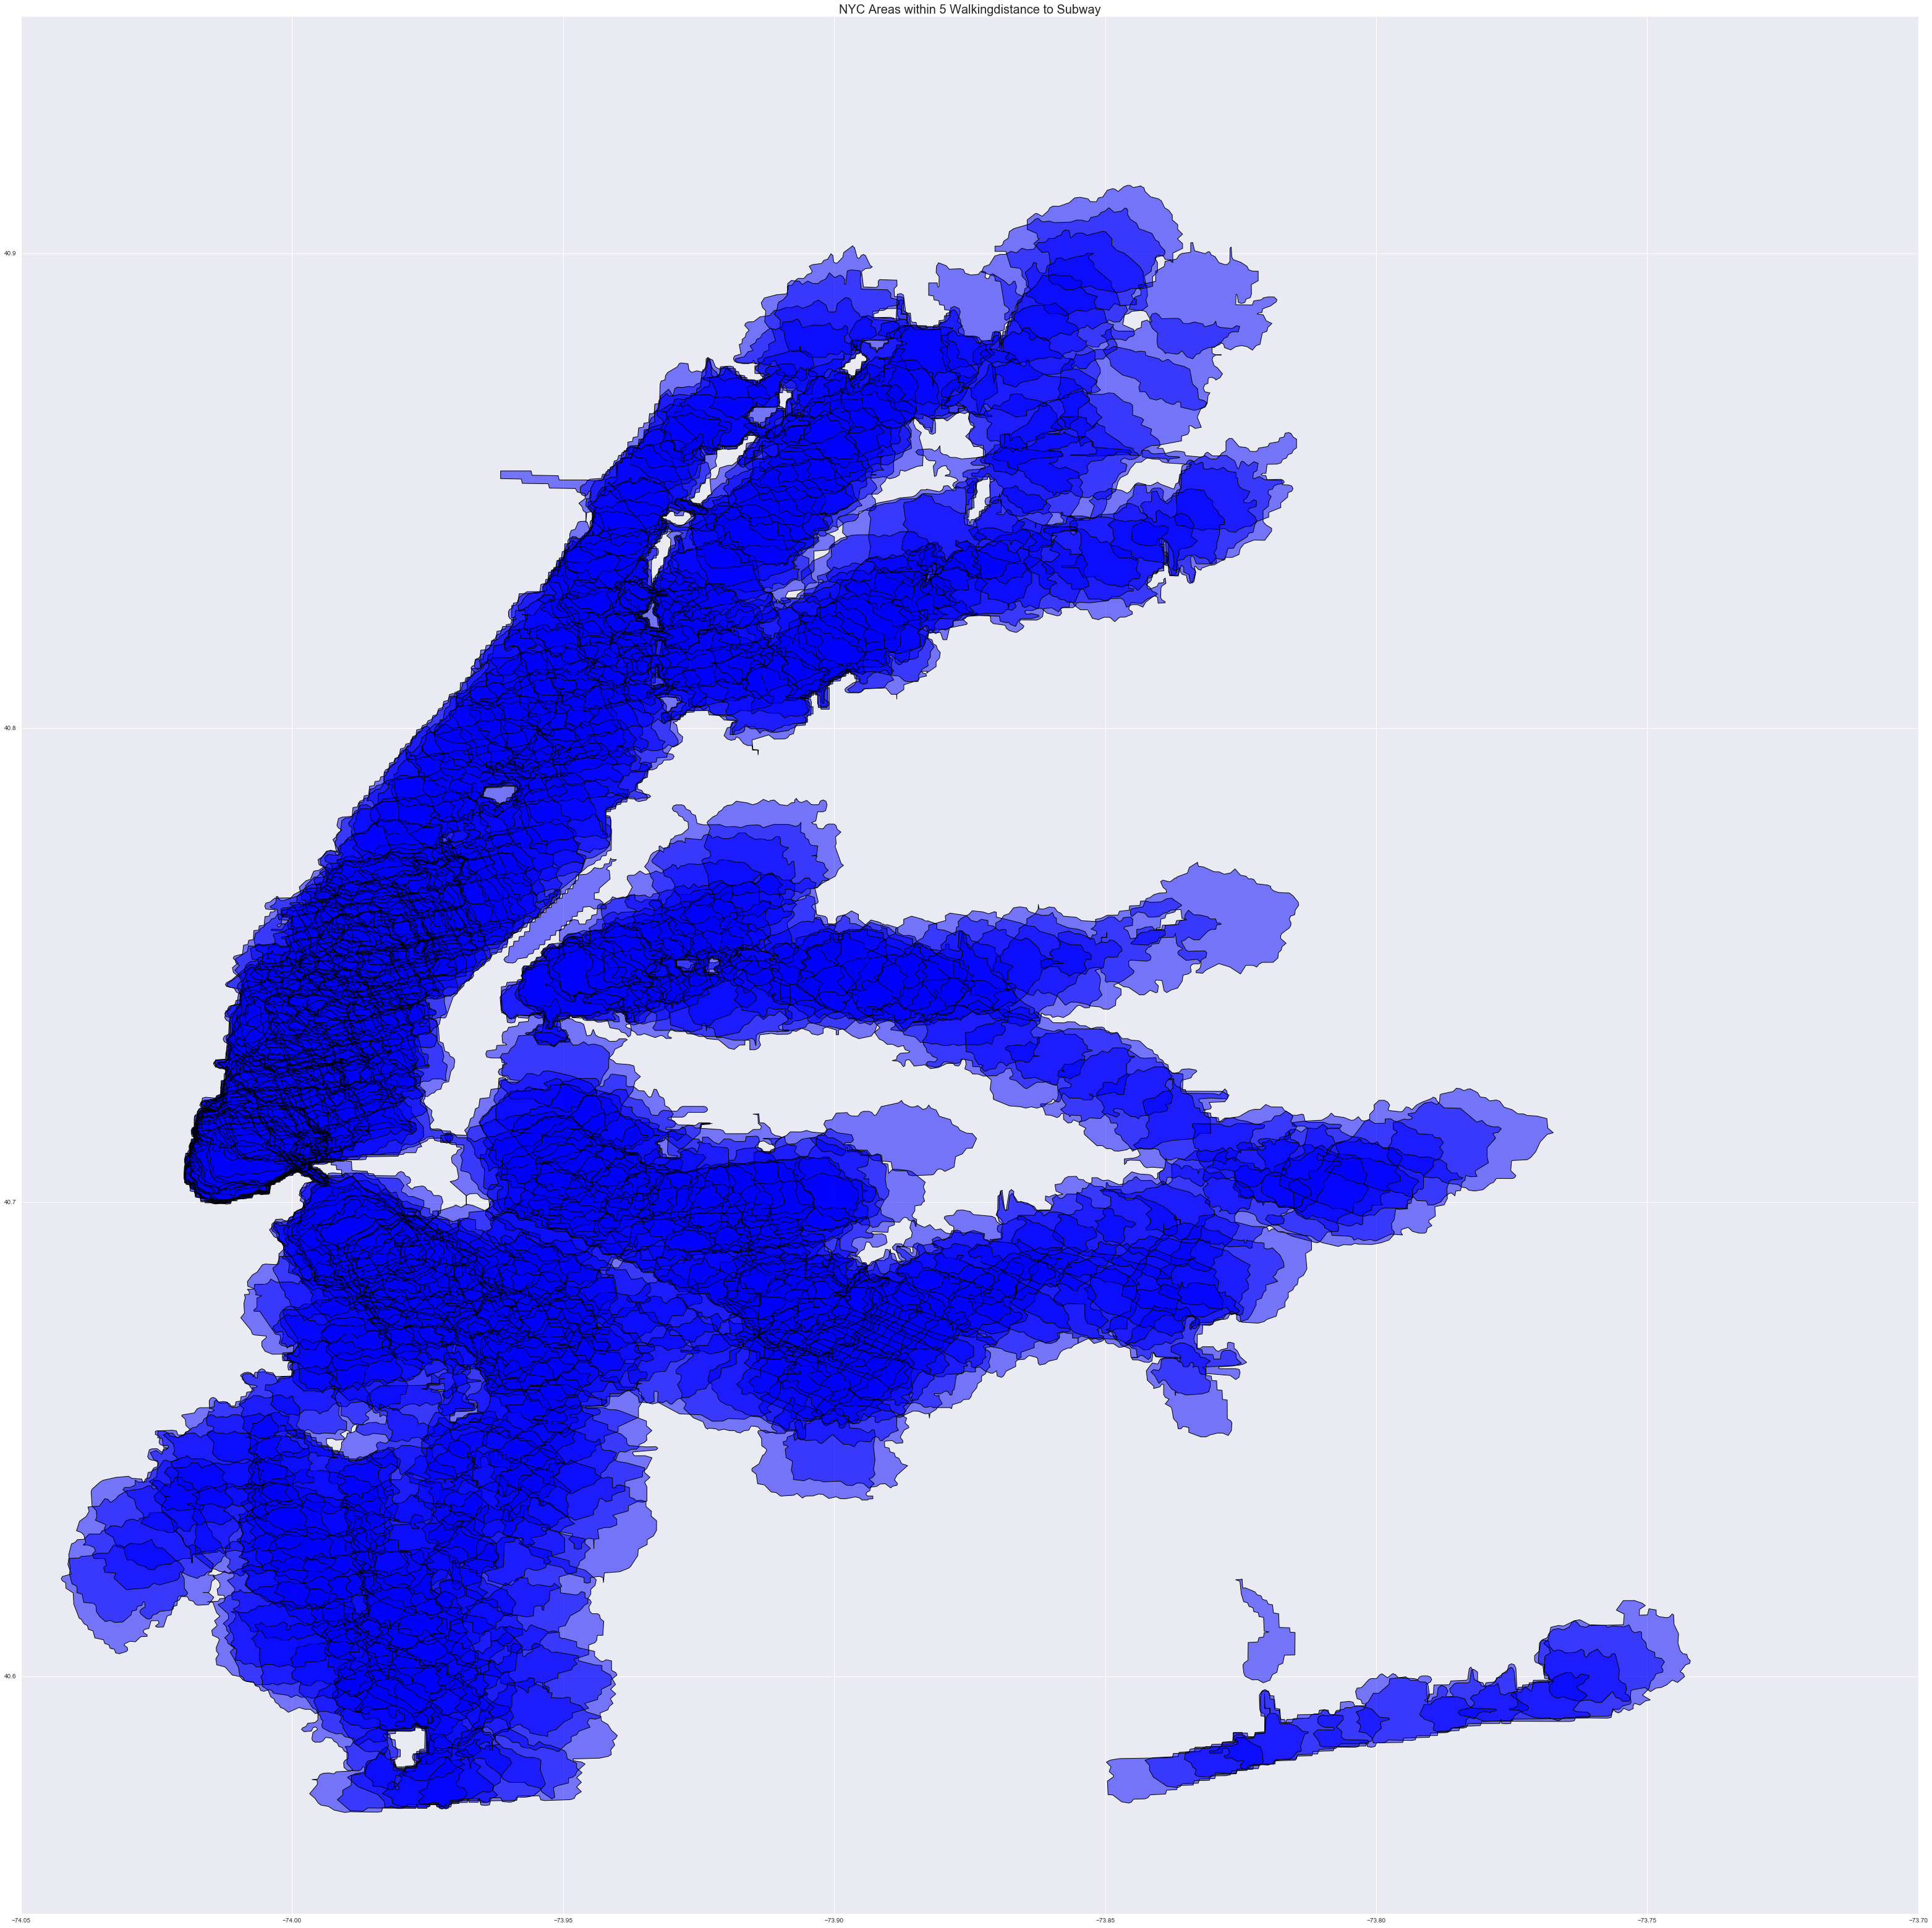

In [15]:
f, ax = pl.subplots(figsize=(55,55))

WDsubStations.plot(linewidth =1, ax = ax,  color='b', label = 'tracks')
#pl.axis('off')
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("NYC Areas within 5 Walkingdistance to Subway", size=20)

In [16]:
with open('15min_Walkingdist_tosubway.geojson', 'w') as f:
    f.write(WDsubStations.to_json())

In [21]:
WDsubStations.crs

{'init': 'epsg:4326', 'no_defs': True}

In [27]:
prj = 'GEOGCS["WGS84(DD)", DATUM["WGS84", SPHEROID["WGS84", 6378137.0, 298.257223563]], PRIMEM["Greenwich", 0.0], UNIT["degree", 0.017453292519943295], AXIS["Geodetic longitude", EAST], AXIS["Geodetic latitude", NORTH]]'

In [23]:

WDsubStations.to_file(filename='bufferstations',driver='ESRI Shapefile',crs_wkt=prj)

In [25]:
boro = gpd.GeoDataFrame.from_file('../Portafolio/Map5/boro/boro.shp')
boro.crs

{}

In [26]:
boro.head()

boro_code      boro_name                                           geometry  \
0         5  Staten Island  (POLYGON ((-74.05050806403247 40.5664220341608...   
1         2          Bronx  (POLYGON ((-73.89680883223774 40.7958084451597...   
2         1      Manhattan  (POLYGON ((-74.01092841268032 40.6844914725429...   
3         3       Brooklyn  (POLYGON ((-73.86706149472119 40.5820879767934...   
4         4         Queens  (POLYGON ((-73.83668274106707 40.5949466970158...   

      shape_area     shape_leng  
0   1623818619.2   330476.02653  
1  1186816232.93   464081.17775  
2  636453966.225  358410.655945  
3  1937484424.68  741039.196851  
4  3044829766.79  895715.765066

In [28]:
boro.to_file(filename='boro',driver='ESRI Shapefile',crs_wkt=prj)

In [15]:
subStationstest = gpd.GeoDataFrame.from_file('Data/5min_Walkingdist_tosubway.geojson')
subStationstest.crs = from_epsg(4326)
subStationstest.head()

geometry id           line  \
0  POLYGON ((-73.988579 40.73473, -73.988297 40.7...  0  4-6-6 Express   
1  POLYGON ((-73.99614 40.723228, -73.99614 40.72...  1  4-6-6 Express   
2  POLYGON ((-73.981216 40.766556, -73.9806520000...  2            1-2   
3  POLYGON ((-73.97275500000001 40.685284, -73.97...  3          2-3-4   
4  POLYGON ((-73.89402 40.669552, -73.892883 40.6...  4            3-4   

               name                                              notes  \
0          Astor Pl  4 nights, 6-all times, 6 Express-weekdays AM s...   
1          Canal St  4 nights, 6-all times, 6 Express-weekdays AM s...   
2           50th St                              1-all times, 2-nights   
3         Bergen St           4-nights, 3-all other times, 2-all times   
4  Pennsylvania Ave                        4-nights, 3-all other times   

  objectid                                url  
0        1  http://web.mta.info/nyct/service/  
1        2  http://web.mta.info/nyct/service/  
2        3  http://web.mta.info/nyct/service/  
3        4  http://web.mta.info/nyct/service/  
4        5  http://web.mta.info/nyct/service/

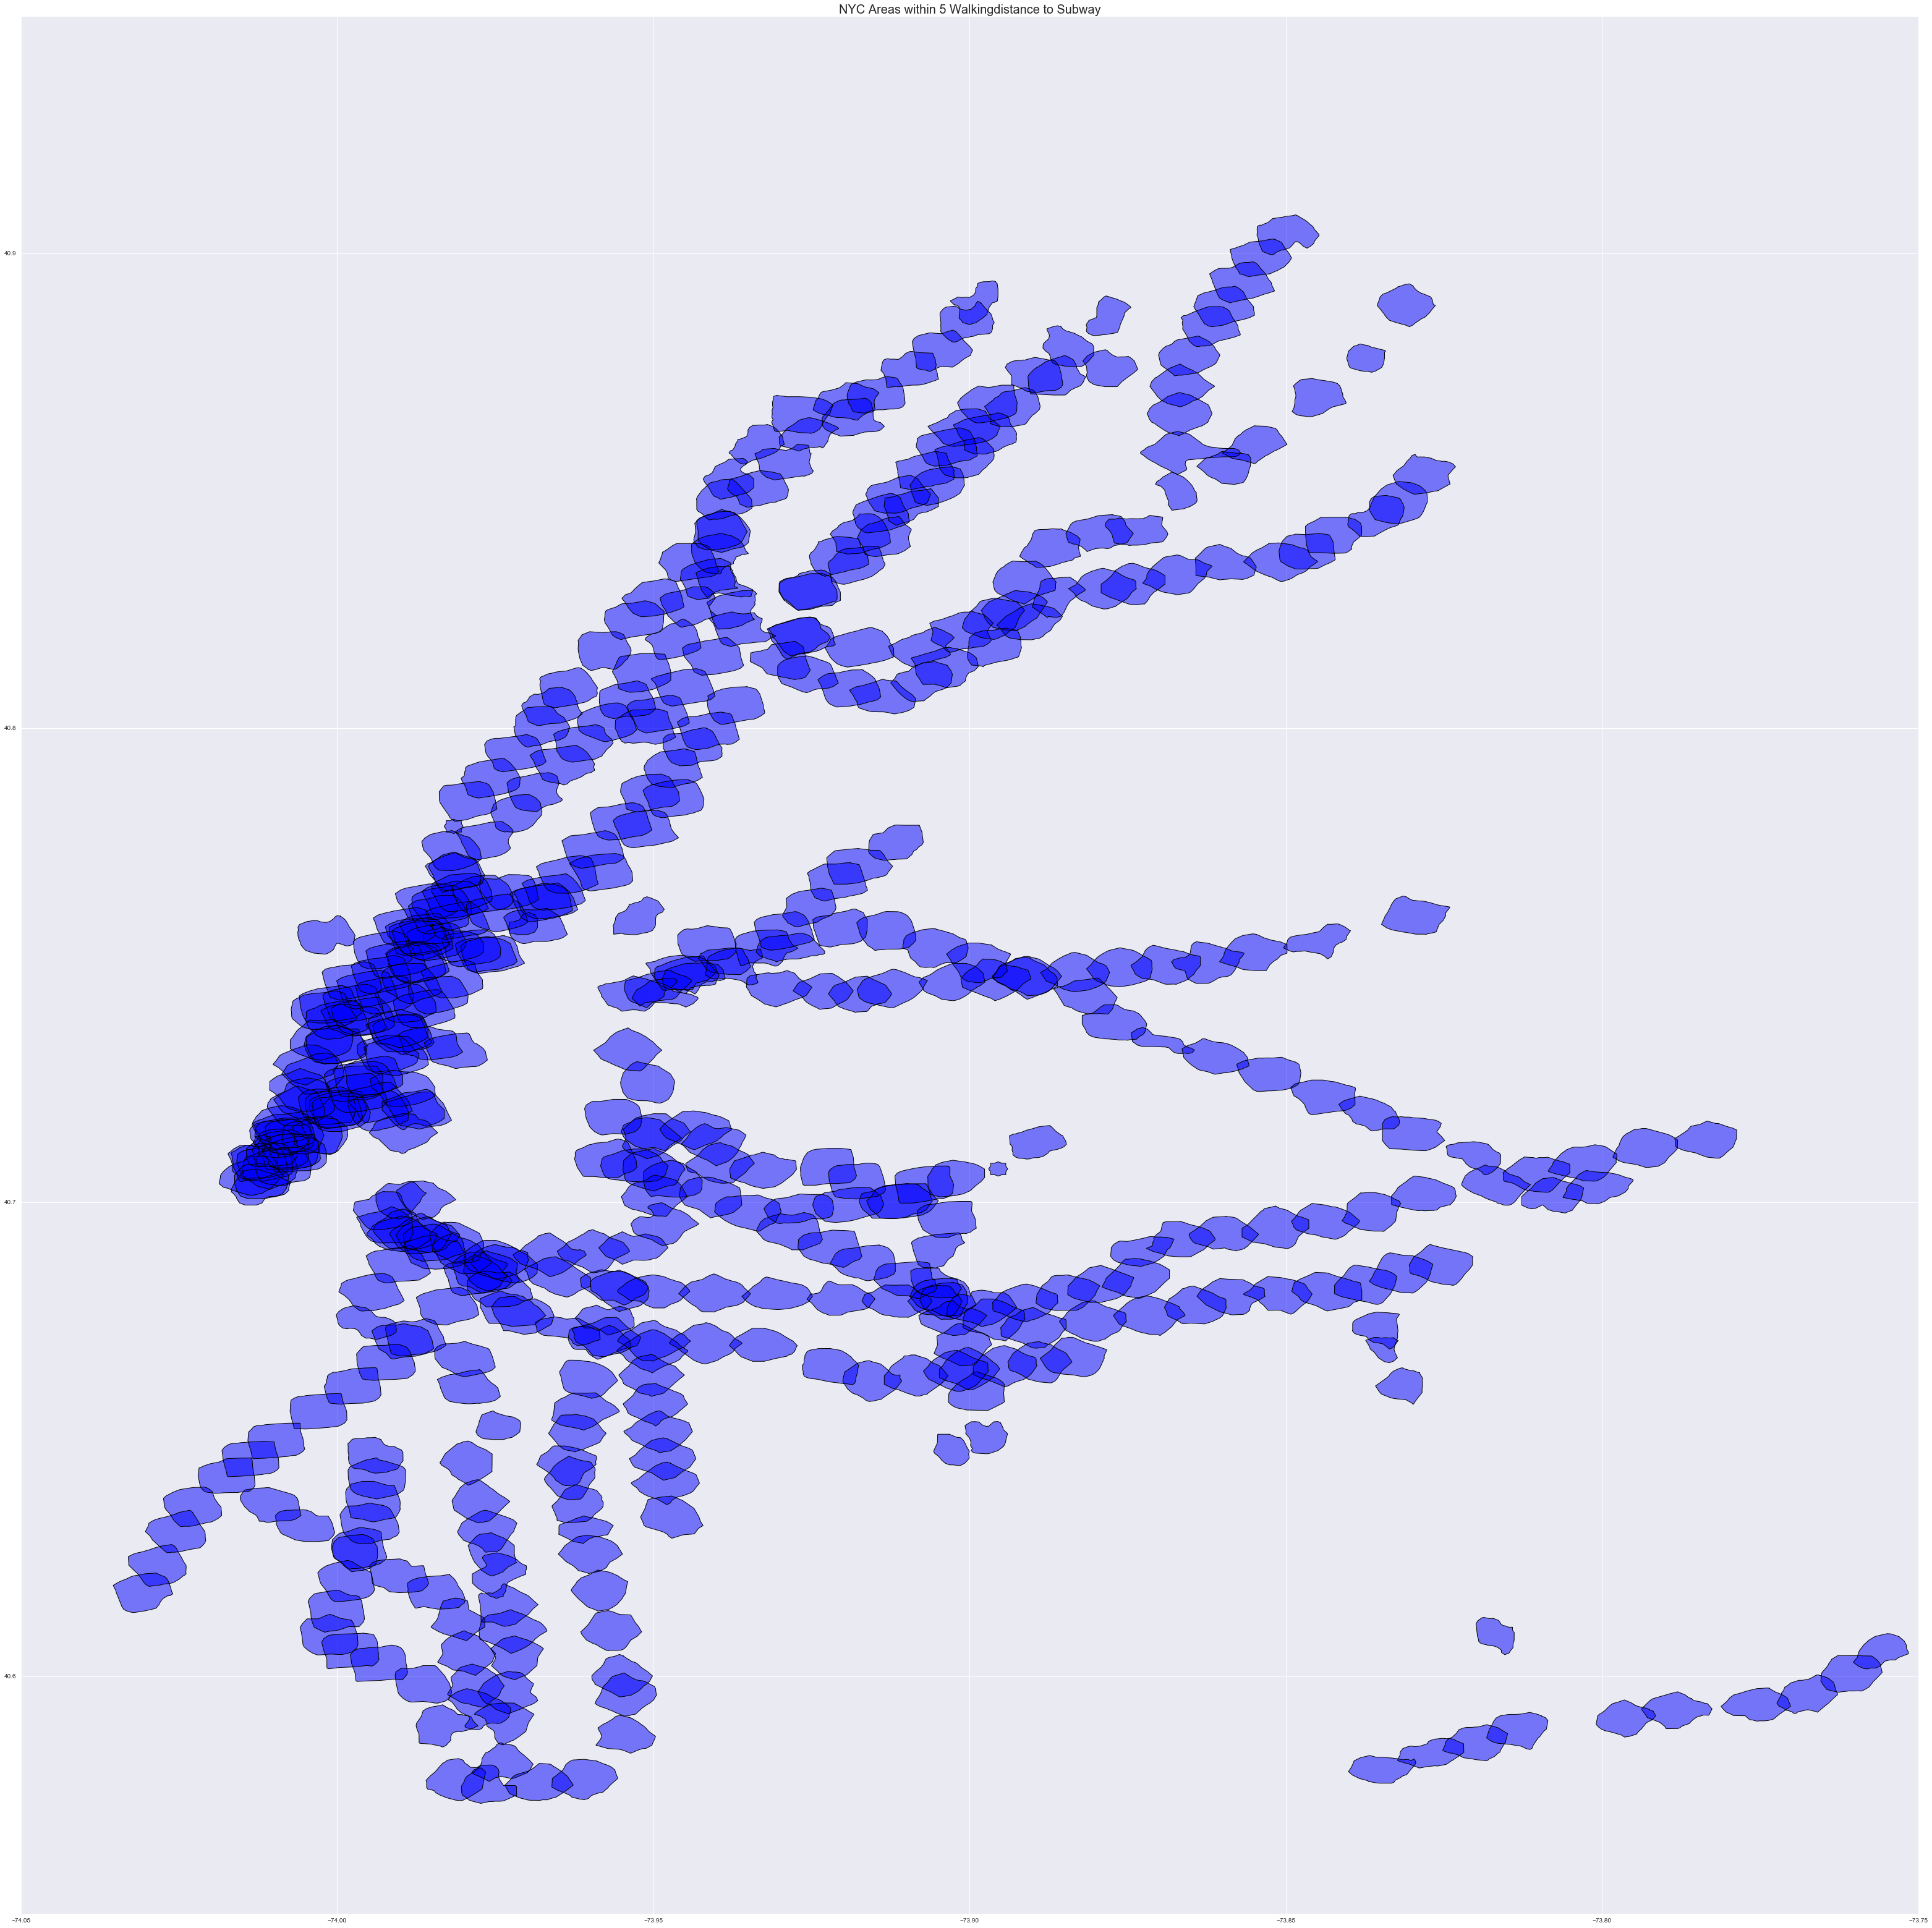

In [16]:
f, ax = pl.subplots(figsize=(55,55))

subStationstest.plot(linewidth =1, ax = ax,  color='b', label = 'tracks')
#pl.axis('off')
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("NYC Areas within 5 Walkingdistance to Subway", size=20)